**El actual experimento consta de poner a prueba una red MLP (Multilayer Perceptron) en el contexto de la predicción multimodal.**

DISCLAIMER: LA EJECUCÓN DE ESTE CÓDIGO FUE EN COLAB, EN LA MAQUINA VIRTUAL DIÓ RESULTADOS DISTINTOS

Entorno en el cual se ejecutó el código.

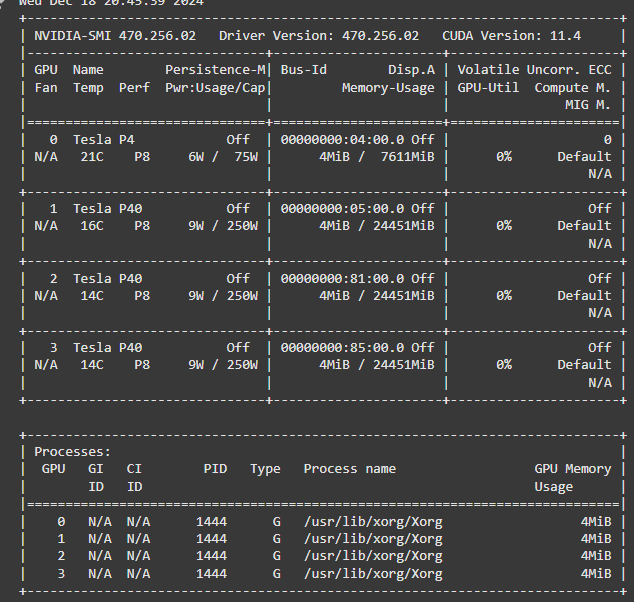

#Imports, set de datos de entrenamiento y testeo y pesos de los modelos ya entrenados

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

from tensorflow.keras.models import load_model
from PIL import Image
from tensorflow import keras
from tensorflow.keras.applications import VGG16, ResNet50, Xception, NASNetLarge, EfficientNetB7, InceptionV3, InceptionResNetV2, MobileNet
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Dropout, BatchNormalization, concatenate, Reshape, Add, Multiply, Lambda, Conv2D, Lambda, Concatenate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



!pip install h3==4.0.0b2 --quiet
!pip show h3
import h3




In [2]:
#!gdown 1XCJzD24CGuPEwvXM9OczWp8h4e_gocDB
!gdown 1eegXBvR-bjpT0vrKAyp3NGq28OC7cqR1#orid_cords.csv
!gdown 1VV3e291qGXmiDyS2Y6Igsowkai93SRQM#hex_df.csv
!gdown 1SU47m_P2hxU354Vv_qfUoVr74VHfJpLC#sets_de_datos
!gdown 1yH7slGrg92hZCIeQZyOrp5oIb_CB_F7l#pesos
!mkdir files
!mkdir pesos
!unzip sets_datos.zip -d files
!unzip pesos.zip -d pesos

x_test_conv = np.load("files/x_test.npy")
x_train_conv = np.load("files/x_train.npy")
y_train = np.load("files/y_train.npy")
y_test = np.load("files/y_test.npy")
y_train_original_scale = np.load("files/y_train_original_scale.npy")
y_test_original_scale = np.load("files/y_test_original_scale.npy")

coordenadas_originales= pd.read_csv("ori_coords.csv")
hex_df= pd.read_csv("hex_df.csv")

Downloading...
From: https://drive.google.com/uc?id=1eegXBvR-bjpT0vrKAyp3NGq28OC7cqR1#orid_cords.csv
To: /content/ori_coords.csv
100% 502/502 [00:00<00:00, 2.85MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1SU47m_P2hxU354Vv_qfUoVr74VHfJpLC#sets_de_datos
From (redirected): https://drive.google.com/uc?id=1SU47m_P2hxU354Vv_qfUoVr74VHfJpLC&confirm=t&uuid=6096ddba-9331-4356-8dc5-56578b44075c
To: /content/sets_datos.zip
100% 9.41M/9.41M [00:00<00:00, 20.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1yH7slGrg92hZCIeQZyOrp5oIb_CB_F7l#pesos
From (redirected): https://drive.google.com/uc?id=1yH7slGrg92hZCIeQZyOrp5oIb_CB_F7l&confirm=t&uuid=b9465df2-f71e-4435-9ceb-14edbecfb0af
To: /content/pesos.zip
100% 294M/294M [00:01<00:00, 189MB/s]
Archive:  sets_datos.zip
  inflating: files/sat.png           
  inflating: files/y_test.npy        
  inflating: files/y_train.npy       
  inflating: files/x_test.npy        
  inflating: files/y_test_original_scale.

Imagen satelital y creación del conjunto de set de datos X con imágenes repetidas

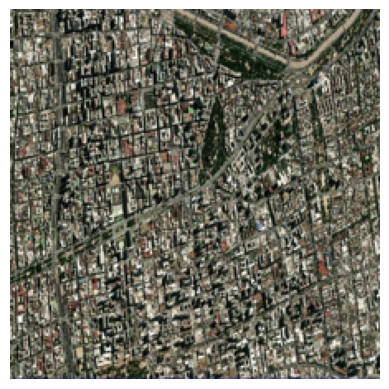

shape de x_train: (1306, 224, 224, 3)
shape de x_test: (272, 224, 224, 3)
shape de y_train: (1306, 1, 44, 15, 1)
shape de y_test: (272, 1, 44, 15, 1)


In [3]:

# Ruta del archivo de la imagen
file_path = 'files/sat.png'

# Abrir la imagen
img = Image.open(file_path)

# Convertir la imagen a RGB
img = img.convert('RGB')

# Cambiar el tamaño de la imagen a 224x224 píxeles
img_resized = img.resize((224, 224))

# Guardar la imagen redimensionada en RGB
img_resized.save('sat_resized_rgb.png')

# Cargar la imagen en RGB
imgg = mpimg.imread('sat_resized_rgb.png')

# Mostrar la imagen en RGB
plt.imshow(imgg)
plt.axis('off')  # Ocultar ejes
plt.show()

# Aplanar la imagen (224x224x3) a (224*224*3,)
imgg_flattened = imgg.reshape(-1, 1)

# Aplicar MinMaxScaler para escalar entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
imgg_scaled = scaler.fit_transform(imgg_flattened)

# Volver a dar forma a la imagen a su tamaño original (224, 224, 3)
imgg_scaled = imgg_scaled.reshape(224, 224, 3)

# Crear x_train con 1294 copias de la imagen
x_train_cnn = np.array([imgg for _ in range(1306)])

# Crear x_test con 260 copias de la imagen
x_test_cnn = np.array([imgg for _ in range(272)])

# Verificar las formas de los conjuntos de datos
print("shape de x_train:", x_train_cnn.shape)
print("shape de x_test:", x_test_cnn.shape)
print("shape de y_train:", y_train.shape)
print("shape de y_test:", y_test.shape)


In [4]:
# Dimensiones de entrada y número de clases
input_shape = (224, 224, 3)  # Mantengo este input_shape para cumplir con los datos de entrada
num_classes = 44 * 15

# Definir la arquitectura del modelo
inputs = Input(shape=input_shape)

# Aplanar las dimensiones de entrada
x = Flatten()(inputs)

# Capas densas

#VER LA ESTRUCTURA OPTIMA
x = Dense(512, activation='relu')(x)
x = Dense(2048, activation='relu')(x)

x = Dense(num_classes, activation='linear')(x)

# Reestructurar la salida a la forma deseada
output_tensor = Reshape((1, 44, 15, 1))(x)

# Crear el modelo
mlp_model = Model(inputs=inputs, outputs=output_tensor)

# Compilar el modelo
mlp_model.compile(optimizer=Adam(learning_rate=0.0002), loss='mean_squared_error')

# # Callbacks para el entrenamiento
# early_stopping = EarlyStopping(monitor="val_loss", patience=15)
# reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, min_lr=1e-6)

# #Entrenamiento del modelo
# start_time = time.time()
# history = mlp_model.fit(
#     x_train_cnn,
#     y_train,
#     batch_size=16,
#     epochs=50,
#     validation_data=(x_test_cnn, y_test),
#     callbacks=[early_stopping, reduce_lr],
# )
# training_time = time.time() - start_time

# # Evaluación del modelo
# test_loss = mlp_model.evaluate(x_test_cnn, y_test)
# train_loss = mlp_model.evaluate(x_train_cnn, y_train)
# minutes_time = training_time / 60

# print(f'Test Loss: {test_loss}')
# print(f'Train Loss: {train_loss}')
# print(f'Training Time: {minutes_time:.1f} minutes')
#mlp_model.summary()
mlp_model.load_weights('pesos/pesos_MLP.h5')

#Modelo francisco


In [6]:
# Define the hexagonal kernel
class HexConstGrid5x3(tf.keras.constraints.Constraint):
    def __init__(self):
        super().__init__()

    def __call__(self, w):
        '''
        [[0, 1, 0],
         [1, 0, 1],
         [0, 1, 0],
         [1, 0, 1],
         [0, 1, 0]]

        '''

        hexaconst=np.ones(w.shape,dtype=np.float32)
        hexaconst[0,0,:,:]=0.0
        hexaconst[0,2,:,:]=0.0
        hexaconst[1,1,:,:]=0.0
        hexaconst[2,0,:,:]=0.0
        hexaconst[2,2,:,:]=0.0
        hexaconst[3,1,:,:]=0.0
        hexaconst[4,0,:,:]=0.0
        hexaconst[4,2,:,:]=0.0

        return w*hexaconst

In [7]:
inp = layers.Input(shape=(None, *x_train_conv.shape[2:]))

# ConvLSTM2D layer
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 3),
    padding="same",
    return_sequences=False,
    activation="relu",
    kernel_constraint=HexConstGrid5x3()
)(inp)

x = layers.BatchNormalization()(x)

# Conv2D layer
x = layers.Conv2D(
    filters=1,
    kernel_size=(3, 3),
    activation="relu",
    padding="same"
)(x)

x = layers.Reshape((1,44,15,1))(x)
# Building the complete model
model_conv_lstm  = keras.models.Model(inp, x)
model_conv_lstm.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam()
)

# model_conv_lstm.summary()

# # Define some callbacks to improve training.
# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# # Define modifiable training hyperparameters.
# epochs = 70
# batch_size = 64

# # #Fit the model to the training data.
# model_conv_lstm.fit(
#     x_train_conv,#input
#     y_train,#output
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data=(x_test_conv, y_test),
#     callbacks=[early_stopping, reduce_lr],
# )
#cargar los pesos
model_conv_lstm.load_weights('pesos/pesos_convLSTM.h5')

#Multi column CNN y CONVLSTM

In [ ]:
print(f"x_train_cnn shape: {x_train_cnn.shape}")
print(f"x_test_cnn shape: {x_test_cnn.shape}")

print(f"\nx_train_conv shape: {x_train_conv.shape}")
print(f"x_test_conv shape: {x_test_conv.shape}")

print(f"\ny_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train_cnn shape: (1306, 224, 224, 3)
x_test_cnn shape: (272, 224, 224, 3)

x_train_conv shape: (1306, 12, 44, 15, 1)
x_test_conv shape: (272, 12, 44, 15, 1)

y_train shape: (1306, 1, 44, 15, 1)
y_test shape: (272, 1, 44, 15, 1)


In [8]:
# Congelar los pesos de la rama de ConvLSTM
for layer in model_conv_lstm.layers:
    layer.trainable = False

# Escalar la salida del modelo y agregar una constante para ajuste
mlp_model_output = mlp_model.output

# Mantener la salida de ConvLSTM sin constantes adicionales, ya que tiene mejor `loss`
conv_lstm_output = model_conv_lstm.output

# Sumar las salidas de los modelos
merged_output = Add()([mlp_model_output, conv_lstm_output])
#merged_output = nasnetlarge_output conv_lstm_output

# Reshape a la forma original de salida
final_output = Reshape((1, 44, 15, 1))(merged_output)

# Crear el modelo final
multi_column_model = Model(inputs=[mlp_model.input, model_conv_lstm.input], outputs=final_output)

# # Compilar el modelo
multi_column_model.compile(optimizer=Adam(learning_rate=0.0002), loss='mean_squared_error')


# # Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# # Entrenar el modelo
start_time = time.time()
multi_column_model.fit(
    [x_train_cnn, x_train_conv],
    y_train,
    batch_size=16,
    epochs=13,#deben ser 50, pero a manera de correrlo rapido se ponen 13
    validation_data=([x_test_cnn, x_test_conv], y_test),
    callbacks=[early_stopping, reduce_lr]
)
training_time = time.time() - start_time

test_loss = multi_column_model.evaluate([x_test_cnn, x_test_conv], y_test)
train_loss = multi_column_model.evaluate([x_train_cnn, x_train_conv], y_train)
minutes_time = training_time / 60
print(f'Test Loss: {test_loss}')
print(f'Train Loss: {train_loss}')
print(f'Training Time: {minutes_time:.1f} minutes')


#model_conv_lstm.load_weights('pesos/pesos_multicolumnMLP.h5')

Epoch 1/8
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - loss: 0.0270 - val_loss: 0.0078 - learning_rate: 2.0000e-04
Epoch 2/8
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - loss: 0.0049 - val_loss: 0.0041 - learning_rate: 2.0000e-04
Epoch 3/8
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 0.0028 - val_loss: 0.0037 - learning_rate: 2.0000e-04
Epoch 4/8
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.0026 - val_loss: 0.0036 - learning_rate: 2.0000e-04
Epoch 5/8
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.0026 - val_loss: 0.0036 - learning_rate: 2.0000e-04
Epoch 6/8
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.0025 - val_loss: 0.0036 - learning_rate: 2.0000e-04
Epoch 7/8
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0025 - val_loss: 0.0036 - learning_rate: 2.0000e-04
Epoch 8/8
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0025 - val_loss: 0.0036 - learning_rate: 2.0000e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 0.0036
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step -

In [ ]:
multi_column_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 flatten_1 (Flatten)            (None, 150528)       0           ['input_2[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, None, 44, 1  0           []                               
                                5, 1)]                                                            
                                                                                            

In [9]:

def ejecutar_prediccion_multi(modelo):
    # Generar predicciones para los conjuntos de entrenamiento y prueba
    train_prediction = modelo.predict([x_train_cnn, x_train_conv])
    test_prediction = modelo.predict([x_test_cnn, x_test_conv])

    # Ajustar el scaler usando los datos de entrenamiento
    scaler = MinMaxScaler()
    scaler.fit(y_train_original_scale.reshape(-1, 15))

    # Función para desnormalizar predicciones
    def desnormalizar(predicciones, scaler, shape):
        pred_reshaped = predicciones.reshape(-1, shape[1])  # Aplana
        pred_original_scale = scaler.inverse_transform(pred_reshaped)
        return pred_original_scale.reshape(-1, shape[0], shape[1])

    # Desnormalizar las predicciones
    train_prediction_original_scale = desnormalizar(train_prediction, scaler, (44, 15))
    test_prediction_original_scale = desnormalizar(test_prediction, scaler, (44, 15))
    # Desnormalizar las salidas reales
    y_train_original_scale_desnormalizado = desnormalizar(y_train, scaler, (44, 15))
    y_test_original_scale_desnormalizado = desnormalizar(y_test, scaler, (44, 15))

    # Función para calcular métricas en 3D
    def calcular_metricas_3d(original_tensor, prediccion_tensor):
        sum_mae, sum_mse, sum_rmse, sum_r2 = 0, 0, 0, 0

        for i in range(original_tensor.shape[0]):
            mae = mean_absolute_error(original_tensor[i], prediccion_tensor[i])
            mse = mean_squared_error(original_tensor[i], prediccion_tensor[i])
            rmse = np.sqrt(mse)
            r2 = r2_score(original_tensor[i].flatten(), prediccion_tensor[i].flatten())

            sum_mae += mae
            sum_mse += mse
            sum_rmse += rmse
            sum_r2 += r2

        avg_mae = sum_mae / original_tensor.shape[0]
        avg_mse = sum_mse / original_tensor.shape[0]
        avg_rmse = sum_rmse / original_tensor.shape[0]
        avg_r2 = sum_r2 / original_tensor.shape[0]

        return avg_mae, avg_mse, avg_rmse, avg_r2

    # Calcular métricas para entrenamiento
    mae_train, mse_train, rmse_train, r2_train = calcular_metricas_3d(
        y_train_original_scale_desnormalizado, train_prediction_original_scale)
    print("Training:")
    print(f"Average MAE: {mae_train:.3f}")
    print(f"Average MSE: {mse_train:.3f}")
    print(f"Average RMSE: {rmse_train:.3f}")
    print(f"Average R^2: {r2_train:.3f}\n")

    # Calcular métricas para prueba
    mae_test, mse_test, rmse_test, r2_test = calcular_metricas_3d(
        y_test_original_scale_desnormalizado, test_prediction_original_scale)
    print("Test:")
    print(f"Average MAE: {mae_test:.3f}")
    print(f"Average MSE: {mse_test:.3f}")
    print(f"Average RMSE: {rmse_test:.3f}")
    print(f"Average R^2: {r2_test:.3f}\n")
    return train_prediction_original_scale, test_prediction_original_scale


In [10]:
def calcular_metricas_3d(original_tensor, prediccion_tensor):
        sum_mae, sum_mse, sum_rmse, sum_r2 = 0, 0, 0, 0

        for i in range(original_tensor.shape[0]):
            mae = mean_absolute_error(original_tensor[i], prediccion_tensor[i])
            mse = mean_squared_error(original_tensor[i], prediccion_tensor[i])
            rmse = np.sqrt(mse)
            r2 = r2_score(original_tensor[i].flatten(), prediccion_tensor[i].flatten())

            sum_mae += mae
            sum_mse += mse
            sum_rmse += rmse
            sum_r2 += r2

        avg_mae = sum_mae / original_tensor.shape[0]
        avg_mse = sum_mse / original_tensor.shape[0]
        avg_rmse = sum_rmse / original_tensor.shape[0]
        avg_r2 = sum_r2 / original_tensor.shape[0]

        return avg_mae, avg_mse, avg_rmse, avg_r2

In [11]:
train_prediction_original_scale, test_prediction_original_scale = ejecutar_prediccion_multi(multi_column_model)

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
Training:
Average MAE: 1.757
Average MSE: 25.184
Average RMSE: 4.898
Average R^2: 0.855

Test:
Average MAE: 2.311
Average MSE: 35.221
Average RMSE: 5.876
Average R^2: 0.837



GRAFICO

In [14]:
def postprocess(arr):
  unshifted_matrix = np.empty_like(arr)
  for i in range(arr.shape[1]):
      n = i
      unshifted_matrix[:, i] = np.concatenate((arr[-n:, i], arr[:-n, i]))

  unpadded_matrix = unshifted_matrix[14:, :]
  downsampled_matrix = unpadded_matrix[::2]

  return downsampled_matrix


In [ ]:
train_prediction_original_scale.shape

(1306, 44, 15)

In [15]:

# Training:
# postprocesamos originales
postprocessed_originals_train = []
for i in range(y_train_original_scale.shape[0]):
    postprocessed_matrix = postprocess(y_train_original_scale[i])
    postprocessed_originals_train.append(postprocessed_matrix)

postprocessed_original_arr_train = np.array(postprocessed_originals_train)

# postprocesamos predicciones
postprocessed_predictions_train = []
for i in range(train_prediction_original_scale.shape[0]):
    postprocessed_matrix = postprocess(train_prediction_original_scale[i])
    postprocessed_predictions_train.append(postprocessed_matrix)

postprocessed_predictions_train.append(postprocessed_matrix)

postprocessed_predictions_arr_train = np.array(postprocessed_predictions_train)
# Testing:
# postprocesamos originales
postprocessed_originals_test = []
for i in range(y_test_original_scale.shape[0]):
    postprocessed_matrix = postprocess(y_test_original_scale[i])
    postprocessed_originals_test.append(postprocessed_matrix)
postprocessed_original_arr_test = np.array(postprocessed_originals_test)

# postprocesamos predicciones
postprocessed_predictions_test = []
for i in range(test_prediction_original_scale.shape[0]):
    postprocessed_matrix = postprocess(test_prediction_original_scale[i])
    postprocessed_predictions_test.append(postprocessed_matrix)

postprocessed_predictions_arr_test = np.array(postprocessed_predictions_test)
# Calcular las métricas promedio
mae, mse, rmse, r2 = calcular_metricas_3d(postprocessed_original_arr_train, postprocessed_predictions_arr_train)

print("Training:")
print(f"MAE promedio: {mae:.3f}")
print(f"MSE promedio: {mse:.3f}")
print(f"RMSE promedio: {rmse:.3f}")
print(f"R^2 promedio: {r2:.3f}")
print("")

mae, mse, rmse, r2 = calcular_metricas_3d(postprocessed_original_arr_test, postprocessed_predictions_arr_test)

print("Test:")
print(f"MAE promedio: {mae:.3f}")
print(f"MSE promedio: {mse:.3f}")
print(f"RMSE promedio: {rmse:.3f}")
print(f"R^2 promedio: {r2:.3f}")
print("")

Training:
MAE promedio: 2.973
MSE promedio: 45.541
RMSE promedio: 6.586
R^2 promedio: 0.806

Test:
MAE promedio: 3.808
MSE promedio: 62.965
RMSE promedio: 7.845
R^2 promedio: 0.786



In [16]:
# definimos función para transformar ambos arrays en dataframes

def array_to_dataframe(arr):
    # Crear listas vacías para cada columna
    ids = []
    is_list = []
    js_list = []
    velocidades = []

    # Iterar sobre el array y llenar las listas
    for id in range(arr.shape[0]):
        for i in range(arr.shape[1]):
            for j in range(arr.shape[2]):
                ids.append(id)
                is_list.append(i)
                js_list.append(j)
                velocidades.append(arr[id, i, j])

    # Crear un dataframe a partir de las listas
    df = pd.DataFrame({
        'id': ids,
        'i': is_list,
        'j': js_list,
        'velocidad': velocidades
    })

    return df
    # Convertimos en dataframes y juntamos actuales vs predicciones

# Training:
df_actuals_train = array_to_dataframe(postprocessed_original_arr_train)
df_preds_train = array_to_dataframe(postprocessed_predictions_arr_train)

df_original_train = df_actuals_train.rename(columns={'velocidad': 'velocidad_actual'})
df_predictions_train = df_preds_train.rename(columns={'velocidad': 'velocidad_predicted'})

df_results_train = pd.merge(df_original_train, df_predictions_train, on=['id','i', 'j'], how='inner')
# ----------------------------#


# Test:
df_actuals_test = array_to_dataframe(postprocessed_original_arr_test)
df_preds_test = array_to_dataframe(postprocessed_predictions_arr_test)

df_original_test = df_actuals_test.rename(columns={'velocidad': 'velocidad_actual'})
df_predictions_test = df_preds_test.rename(columns={'velocidad': 'velocidad_predicted'})

df_results_test = pd.merge(df_original_test, df_predictions_test, on=['id','i', 'j'], how='inner')

In [17]:
results_110_train = pd.merge(coordenadas_originales, df_results_train, on=['i','j'])
results_110_test = pd.merge(coordenadas_originales, df_results_test, on=['i','j'])

<ipython-input-18-210648560ba1>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_scores = df.groupby(['i', 'j']).apply(calculate_mae).unstack()


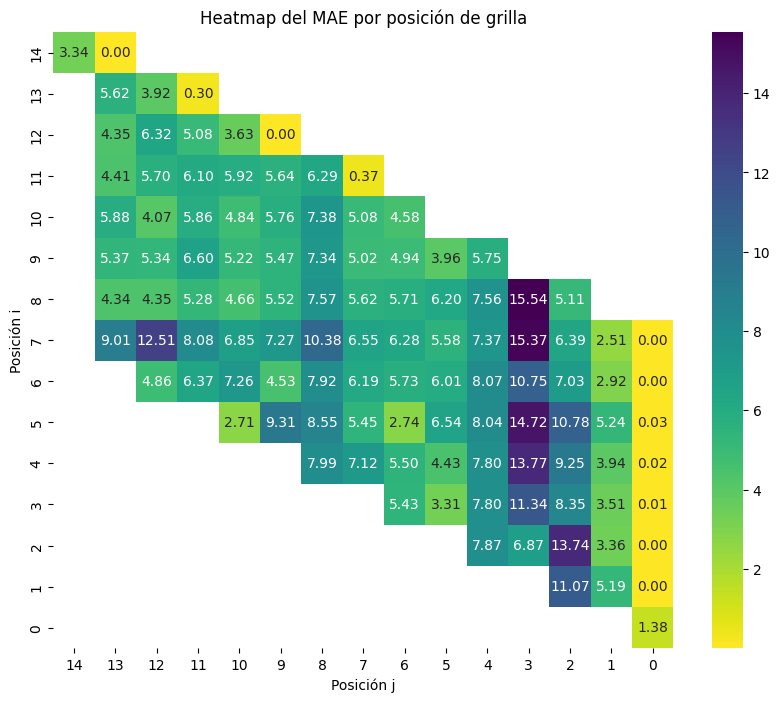

In [18]:
df = results_110_train.copy()

# Asumiendo que df es tu DataFrame

# Definimos una función para calcular el MAE por grupo
def calculate_mae(group):
    actual = group['velocidad_actual']
    predicted = group['velocidad_predicted']
    return mean_absolute_error(actual, predicted)

# Aplicamos la función de cálculo del MAE a cada combinación de 'i' y 'j'
mae_scores = df.groupby(['i', 'j']).apply(calculate_mae).unstack()

# Creamos el heatmap con Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(mae_scores, annot=True, fmt=".2f", cmap='viridis_r')
plt.title('Heatmap del MAE por posición de grilla')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('Posición j')
plt.ylabel('Posición i')
plt.show()

<ipython-input-19-081ddf70c38a>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_scores = df.groupby(['i', 'j']).apply(calculate_mae).unstack()


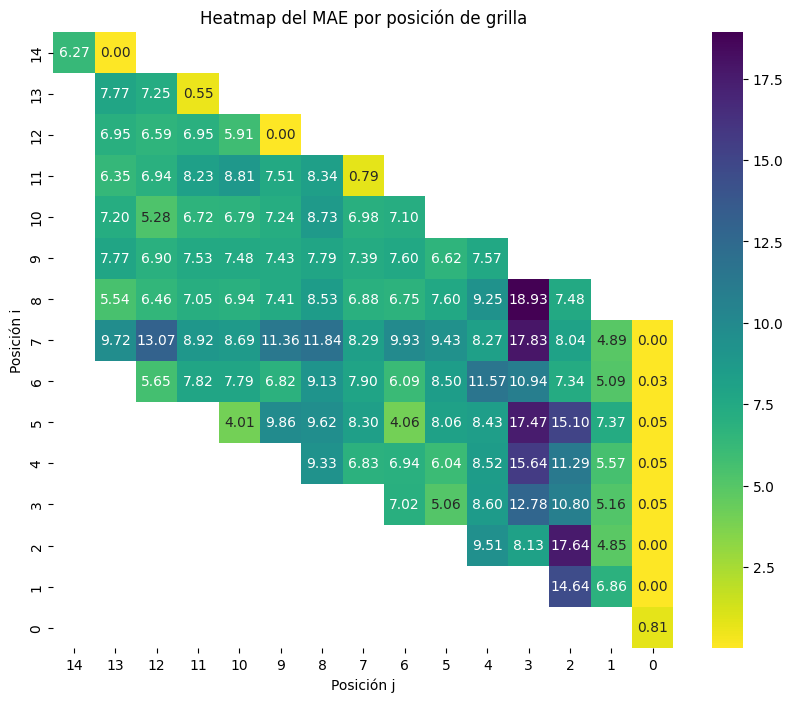

In [19]:
df = results_110_test.copy()

# Asumiendo que df es tu DataFrame

# Definimos una función para calcular el MAE por grupo
def calculate_mae(group):
    actual = group['velocidad_actual']
    predicted = group['velocidad_predicted']
    return mean_absolute_error(actual, predicted)

# Aplicamos la función de cálculo del MAE a cada combinación de 'i' y 'j'
mae_scores = df.groupby(['i', 'j']).apply(calculate_mae).unstack()

# Creamos el heatmap con Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(mae_scores, annot=True, fmt=".2f", cmap='viridis_r')
plt.title('Heatmap del MAE por posición de grilla')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('Posición j')
plt.ylabel('Posición i')
plt.show()

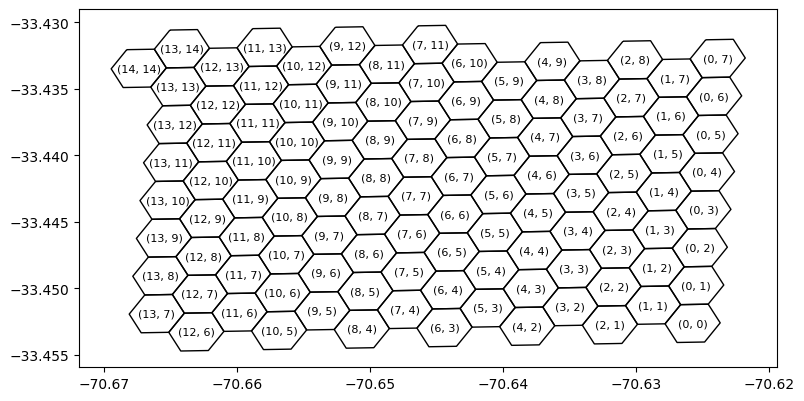

In [24]:
hex_df_geom = hex_df.copy()
# Converting H3 identifiers into polygons
hex_df_geom['geometry'] = hex_df_geom['h3'].apply(lambda x:Polygon(h3.cell_to_boundary(h=x, geo_json=True)))

gdf = gpd.GeoDataFrame(hex_df_geom.drop_duplicates(subset=['i', 'j']), geometry='geometry')
fig, ax = plt.subplots(figsize=(9, 9))

# Drawing the hexagons
gdf.plot(ax=ax, edgecolor='black', facecolor='none')

# Adding the (i, j) coordinates to each hexagon.
for x, y, i, j in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf['i'], gdf['j']):
    coord_text = f"({j}, {i})"
    ax.text(x, y, coord_text, horizontalalignment='center', verticalalignment='center', fontsize=8)

ax.set_title("")
plt.show()

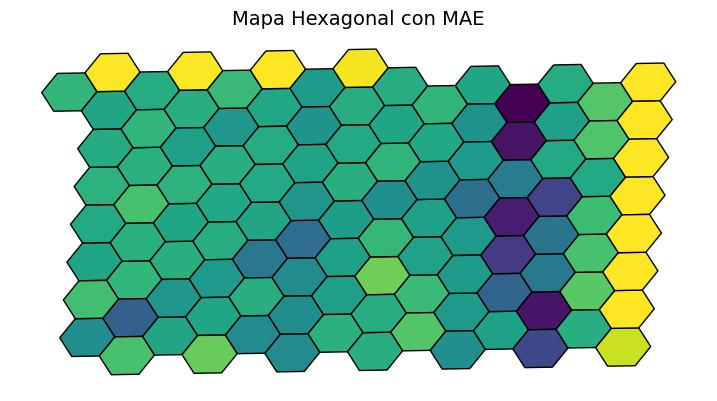

In [ ]:
# Asumiendo que df es tu DataFrame con columnas ['i', 'j', 'velocidad_actual', 'velocidad_predicted']
# Definimos una función para calcular el MAE por grupo
def calculate_mae(group):
    actual = group['velocidad_actual']
    predicted = group['velocidad_predicted']
    return mean_absolute_error(actual, predicted)

# Aplicamos la función de cálculo del MAE a cada combinación de 'i' y 'j'
mae_scores = df.groupby(['i', 'j']).apply(calculate_mae).unstack()

# Preparar un DataFrame con H3 y las coordenadas (i, j)
hex_df_geom = hex_df.copy()
hex_df_geom['geometry'] = hex_df_geom['h3'].apply(lambda x: Polygon(h3.cell_to_boundary(h=x, geo_json=True)))

# Crear el GeoDataFrame
gdf = gpd.GeoDataFrame(hex_df_geom.drop_duplicates(subset=['i', 'j']), geometry='geometry')

# Añadir el MAE al GeoDataFrame
def get_mae(row):
    try:
        return mae_scores.loc[row['i'], row['j']]
    except KeyError:
        return np.nan

gdf['mae'] = gdf.apply(get_mae, axis=1)

# Normalizamos los valores de MAE para los colores
min_val, max_val = gdf['mae'].min(), gdf['mae'].max()
gdf['normalized_mae'] = (gdf['mae'] - min_val) / (max_val - min_val)

# Graficamos los hexágonos con colores basados en el MAE
fig, ax = plt.subplots(figsize=(9, 9))

# Dibujar los hexágonos con un mapa de colores basado en los valores normalizados
gdf.plot(
    ax=ax,
    edgecolor='black',
    column='normalized_mae',
    cmap='viridis_r',
    legend=False
)

# Eliminar los márgenes
ax.set_axis_off()

# Agregar las coordenadas (i, j) a cada hexágono
# Eliminar las coordenadas del gráfico
# for x, y, i, j in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf['i'], gdf['j']):
#     coord_text = f"({j}, {i})"
#     ax.text(x, y, coord_text, horizontalalignment='center', verticalalignment='center', fontsize=8)

ax.set_title("Mapa Hexagonal con MAE", fontsize=14)
plt.show()


#Opcional

Modelo FiLM que fue probado como manera de mejorar la MLP, pero no empeoró los resultados obtenidos anteriormente.

In [ ]:
# Congelar los pesos de la rama de ConvLSTM
for layer in model_conv_lstm.layers:
    layer.trainable = False

# Escalar la salida del modelo y agregar una constante para ajuste
mlp_model_output = mlp_model.output# * 0.8 + tf.constant(0.05)  # Escalar al 30% y agregar una constante menor

# Mantener la salida de ConvLSTM sin constantes adicionales, ya que tiene mejor `loss`
conv_lstm_output = model_conv_lstm.output  # Sin cambios

# Generar parámetros FiLM desde la salida del MLP
film_scale = Dense(1, activation='linear', name="film_scale")(mlp_model_output)
film_shift = Dense(1, activation='linear', name="film_shift")(mlp_model_output)

# Aplicar FiLM a la salida del ConvLSTM
scaled_conv_lstm_output = Multiply()([conv_lstm_output, film_scale])
film_output = Add()([scaled_conv_lstm_output, film_shift])

# Combinar las salidas
combined_output = Add()([film_output, mlp_model_output])
# Combinar la salida modulada con otra salida si es necesario
# Aquí asumimos que la salida del MLP también contribuye al modelo combinado

# Reestructurar salida final
final_output = Reshape((1, 44, 15, 1))(combined_output)

# Crear el modelo final
multi_column_model = Model(inputs=[mlp_model.input, model_conv_lstm.input], outputs=final_output)

# Compilar el modelo
multi_column_model.compile(optimizer=Adam(learning_rate=0.0002), loss='mean_squared_error')

# Entrenar el modelo
start_time = time.time()
multi_column_model.fit(
    [x_train_cnn, x_train_conv],
    y_train,
    batch_size=16,
    epochs=50,
    validation_data=([x_test_cnn, x_test_conv], y_test),
    callbacks=[early_stopping, reduce_lr]
)
training_time = time.time() - start_time

test_loss = multi_column_model.evaluate([x_test_cnn, x_test_conv], y_test)
train_loss = multi_column_model.evaluate([x_train_cnn, x_train_conv], y_train)
minutes_time = training_time / 60
print(f'Test Loss: {test_loss}')
print(f'Train Loss: {train_loss}')
print(f'Training Time: {minutes_time:.1f} minutes')

Para evaluar la MLP de manera singular, sin multicolumna.

In [ ]:

def ejecutar_prediccion(modelo):
    # Generar predicciones para los conjuntos de entrenamiento y prueba
    train_prediction = modelo.predict(x_train_cnn)
    test_prediction = modelo.predict(x_test_cnn)

    # Ajustar el scaler usando los datos de entrenamiento
    scaler = MinMaxScaler()
    scaler.fit(y_train_original_scale.reshape(-1, 15))

    # Función para desnormalizar predicciones
    def desnormalizar(predicciones, scaler, shape):
        pred_reshaped = predicciones.reshape(-1, shape[1])  # Aplana
        pred_original_scale = scaler.inverse_transform(pred_reshaped)
        return pred_original_scale.reshape(-1, shape[0], shape[1])

    # Desnormalizar las predicciones
    train_prediction_original_scale = desnormalizar(train_prediction, scaler, (44, 15))
    test_prediction_original_scale = desnormalizar(test_prediction, scaler, (44, 15))

    # Desnormalizar las salidas reales
    y_train_original_scale_desnormalizado = desnormalizar(y_train, scaler, (44, 15))
    y_test_original_scale_desnormalizado = desnormalizar(y_test, scaler, (44, 15))

    # Función para calcular métricas en 3D
    def calcular_metricas_3d(original_tensor, prediccion_tensor):
        sum_mae, sum_mse, sum_rmse, sum_r2 = 0, 0, 0, 0

        for i in range(original_tensor.shape[0]):
            mae = mean_absolute_error(original_tensor[i], prediccion_tensor[i])
            mse = mean_squared_error(original_tensor[i], prediccion_tensor[i])
            rmse = np.sqrt(mse)
            r2 = r2_score(original_tensor[i].flatten(), prediccion_tensor[i].flatten())

            sum_mae += mae
            sum_mse += mse
            sum_rmse += rmse
            sum_r2 += r2

        avg_mae = sum_mae / original_tensor.shape[0]
        avg_mse = sum_mse / original_tensor.shape[0]
        avg_rmse = sum_rmse / original_tensor.shape[0]
        avg_r2 = sum_r2 / original_tensor.shape[0]

        return avg_mae, avg_mse, avg_rmse, avg_r2

    # Calcular métricas para entrenamiento
    mae_train, mse_train, rmse_train, r2_train = calcular_metricas_3d(
        y_train_original_scale_desnormalizado, train_prediction_original_scale)
    print("Training:")
    print(f"Average MAE: {mae_train:.3f}")
    print(f"Average MSE: {mse_train:.3f}")
    print(f"Average RMSE: {rmse_train:.3f}")
    print(f"Average R^2: {r2_train:.3f}\n")

    # Calcular métricas para prueba
    mae_test, mse_test, rmse_test, r2_test = calcular_metricas_3d(
        y_test_original_scale_desnormalizado, test_prediction_original_scale)
    print("Test:")
    print(f"Average MAE: {mae_test:.3f}")
    print(f"Average MSE: {mse_test:.3f}")
    print(f"Average RMSE: {rmse_test:.3f}")
    print(f"Average R^2: {r2_test:.3f}\n")
ejecutar_prediccion(mlp_model)
